In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import numpy as np 
from tqdm.notebook import tqdm 
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms as T
from torchvision.datasets import ImageFolder

# Load

In [4]:
transforms_simple = T.Compose([
    T.ToTensor(), 
])

train_folder = ImageFolder('tiny-imagenet-200/train', transform=transforms_simple)
val_folder = ImageFolder('tiny-imagenet-200/val', transform=transforms_simple)
test_folder = ImageFolder('tiny-imagenet-200/test', transform=transforms_simple)


train_loader = torch.utils.data.DataLoader(
    train_folder,
    batch_size=128,
    shuffle=True,
    num_workers=16
)

val_loader = torch.utils.data.DataLoader(
    val_folder,
    batch_size=128,
    shuffle=True,
    num_workers=16
)

test_loader = torch.utils.data.DataLoader(
    test_folder,
    batch_size=128,
    shuffle=True,
    num_workers=16
)

In [5]:
mean = torch.zeros(3, dtype=float)
mean_sq = torch.zeros(3, dtype=float)
n = len(train_loader)

for x, _ in train_loader:
    mean += torch.mean(x, dim=(0, 2, 3))
    mean_sq += torch.mean(x ** 2, dim=(0, 2, 3))

mean /= n
mean_sq /= n
std = torch.sqrt(mean_sq - mean ** 2)

In [6]:
mean

tensor([0.4803, 0.4481, 0.3976], dtype=torch.float64)

In [7]:
std

tensor([0.2770, 0.2690, 0.2821], dtype=torch.float64)

In [8]:
def tensor_to_image(tensor, mean=(0.5, 0.5, 0.5), std=(0.25, 0.25, 0.25)):
    # mean, std ->
    mean = torch.tensor(mean)[:, None, None]
    std = torch.tensor(std)[:, None, None]

    renormalized_tensor = mean + std * tensor
    image = renormalized_tensor.permute(1, 2, 0).detach().cpu().numpy()

    return image

In [9]:
num_classes = len(train_folder.class_to_idx)

# Model

In [10]:
# def layer_init(m):
#     classname = m.__class__.__name__
#     classname = classname.lower()
#     if classname.find('conv') != -1 or classname.find('linear') != -1:
#         gain = nn.init.calculate_gain(classname)
#         nn.init.xavier_uniform_(m.weight, gain=gain)
#         if m.bias is not None:
#             nn.init.constant_(m.bias, 0)
#     elif classname.find('batchnorm') != -1:
#         nn.init.constant_(m.weight, 1)
#         if m.bias is not None:
#             nn.init.constant_(m.bias, 0)
#     elif classname.find('embedding') != -1:

#         num_columns = m.weight.size(1)
#         sigma = 1/(num_columns**0.5)
#         m.weight.data.normal_(0, sigma).clamp_(-3*sigma, 3*sigma)

In [11]:
class Inception_base(nn.Module):
    def __init__(self, depth_dim, input_size, config):
        super(Inception_base, self).__init__()
        self.depth_dim = depth_dim
        # 1x1
        self.conv1 = nn.Conv2d(input_size, out_channels=config[0][0], kernel_size=1, stride=1, padding=0)
        # 3x3_bottleneck + 3x3
        self.conv3_1 = nn.Conv2d(input_size, out_channels=config[1][0], kernel_size=1, stride=1, padding=0)
        self.conv3_3 = nn.Conv2d(config[1][0], config[1][1], kernel_size=3, stride=1, padding=1)
        # 5x5_bottleneck + 5x5
        self.conv5_1 = nn.Conv2d(input_size, out_channels=config[2][0], kernel_size=1, stride=1, padding=0)
        self.conv5_5 = nn.Conv2d(config[2][0], config[2][1], kernel_size=5, stride=1, padding=2)
        # maxpool + 1x1
        self.max_pool_1 = nn.MaxPool2d(kernel_size=config[3][0], stride=1, padding=1)
        self.conv_max_1 = nn.Conv2d(input_size, out_channels=config[3][1], kernel_size=1, stride=1, padding=0)
        
        # self.apply(layer_init)

    def forward(self, input):
        output1 = F.relu(self.conv1(input))
        output2 = F.relu(self.conv3_1(input))
        output2 = F.relu(self.conv3_3(output2))
        output3 = F.relu(self.conv5_1(input))
        output3 = F.relu(self.conv5_5(output3))
        output4 = F.relu(self.conv_max_1(self.max_pool_1(input)))
        return torch.cat([output1, output2, output3, output4], dim=self.depth_dim)

In [12]:
class LRN(nn.Module):

    '''
    Implementing Local Response Normalization layer. Implemention adapted
    from https://github.com/jiecaoyu/pytorch_imagenet/blob/master/networks/model_list/alexnet.py
    '''

    def __init__(self, local_size=1, alpha=1.0, beta=0.75, k=1, ACROSS_CHANNELS=False):
        super(LRN, self).__init__()
        self.ACROSS_CHANNELS = ACROSS_CHANNELS
        if ACROSS_CHANNELS:
            self.average=nn.AvgPool3d(kernel_size=(local_size, 1, 1),
                    stride=1,
                    padding=(int((local_size-1.0)/2), 0, 0))
        else:
            self.average=nn.AvgPool2d(kernel_size=local_size,
                    stride=1,
                    padding=int((local_size-1.0)/2))
        self.alpha = alpha
        self.beta = beta
        self.k = k

    def forward(self, x):
        if self.ACROSS_CHANNELS:
            div = x.pow(2).unsqueeze(1)
            div = self.average(div).squeeze(1)
            div = div.mul(self.alpha).add(self.k).pow(self.beta)
        else:
            div = x.pow(2)
            div = self.average(div)
            div = div.mul(self.alpha).add(self.k).pow(self.beta)
        x = x.div(div)
        return x

In [13]:
class Inception_v1(nn.Module):
    def __init__(self, num_classes=1000):
        super(Inception_v1, self).__init__()

        #conv2d0
        self.conv1 = nn.Conv2d(3, 192, kernel_size=7, stride=1, padding=0)
        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.lrn1 = LRN(local_size=11, alpha=0.00109999999404, beta=0.5, k=2)

        #conv2d1
        # self.conv2 = nn.Conv2d(64, 64, kernel_size=1, stride=1, padding=0)

        #conv2d2
        # self.conv3  = nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=0)
        # self.lrn3 = LRN(local_size=11, alpha=0.00109999999404, beta=0.5, k=2)
        # self.max_pool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception_3a = Inception_base(1, 192, [[64], [96,128], [16, 32], [3, 32]]) #3a
        self.inception_3b = Inception_base(1, 256, [[128], [128,192], [32, 96], [3, 64]]) #3b
        self.max_pool_inc3= nn.MaxPool2d(kernel_size=3, stride=2, padding=0)

        self.inception_4a = Inception_base(1, 480, [[192], [ 96,204], [16, 48], [3, 64]]) #4a
        self.inception_4b = Inception_base(1, 508, [[160], [112,224], [24, 64], [3, 64]]) #4b
        self.inception_4c = Inception_base(1, 512, [[128], [128,256], [24, 64], [3, 64]]) #4c
        self.inception_4d = Inception_base(1, 512, [[112], [144,288], [32, 64], [3, 64]]) #4d
        self.inception_4e = Inception_base(1, 528, [[256], [160,320], [32,128], [3,128]]) #4e
        self.max_pool_inc4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception_5a = Inception_base(1, 832, [[256], [160,320], [48,128], [3,128]]) #5a
        self.inception_5b = Inception_base(1, 832, [[384], [192,384], [48,128], [3,128]]) #5b
        self.avg_pool5 = nn.AvgPool2d(kernel_size=7, stride=1, padding=0)

        self.dropout_layer = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)

        # self.apply(layer_init)

    def forward(self, input):

        output = self.max_pool1(F.relu(self.conv1(input)))
        output = self.lrn1(output)

        # output = F.relu(self.conv2(output))
        # output = F.relu(self.conv3(output))
        # output = self.max_pool3(self.lrn3(output))

        output = self.inception_3a(output)
        output = self.inception_3b(output)
        output = self.max_pool_inc3(output)

        output = self.inception_4a(output)
        output = self.inception_4b(output)
        output = self.inception_4c(output)
        output = self.inception_4d(output)
        output = self.inception_4e(output)
        output = self.max_pool_inc4(output)

        output = self.inception_5a(output)
        output = self.inception_5b(output)
        output = self.avg_pool5(output)

        output = output.view(-1, 1024)

        if self.fc is not None:
            output = self.dropout_layer(output)
            output = self.fc(output)

        return output

In [14]:
model = Inception_v1(200)

# Wandb

# Train

In [15]:
import wandb

config = {
    "learning_rate": 3e-4,
    "weight_decay": 0.05,
    "batch_size": 128,
    "num_epochs": 25,
    "optimizer": torch.optim.AdamW,
}

wandb.init(
    # set the wandb project where this run will be logged
    project="hw2",
    name="HooLeNet",
    reinit=True,
    # track hyperparameters and run metadata
    config=config,
)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: grach0v (cowboy_bebop). Use `wandb login --relogin` to force relogin


In [16]:
def tensor_to_image(tensor, mean=(0.5, 0.5, 0.5), std=(0.25, 0.25, 0.25)):
    # mean, std ->
    mean = torch.tensor(mean)[:, None, None]
    std = torch.tensor(std)[:, None, None]

    renormalized_tensor = mean + std * tensor
    image = renormalized_tensor.permute(1, 2, 0).detach().cpu().numpy()

    return image

In [17]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [18]:
transforms_simple = T.Compose([
    T.ToTensor(), 
    T.RandomHorizontalFlip(),
    T.RandomRotation(degrees=15),
    T.Normalize(mean, std) # по-хорошему нужно брать из датасета
])

train_folder = ImageFolder('tiny-imagenet-200/train', transform=transforms_simple)
val_folder = ImageFolder('tiny-imagenet-200/val', transform=transforms_simple)
test_folder = ImageFolder('tiny-imagenet-200/test', transform=transforms_simple)


train_loader = torch.utils.data.DataLoader(
    train_folder,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=16
)

val_loader = torch.utils.data.DataLoader(
    val_folder,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=16
)

test_loader = torch.utils.data.DataLoader(
    test_folder,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=16
)

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = config["optimizer"](
    model.parameters(), 
    lr=config["learning_rate"], 
    weight_decay=config["weight_decay"]
)

In [20]:
def run_epoch(stage, model, dataloader, loss_fn, optimizer, epoch, device):
    # v NOTE THIS v
    if stage == "train":
        model.train()
        torch.set_grad_enabled(True)
    else:
        torch.set_grad_enabled(False)
        model.eval()
    # ^ NOTE THIS ^

    model = model.to(device)

    losses = []
    for batch in tqdm(dataloader, total=len(dataloader), desc=f"epoch: {str(epoch).zfill(3)} | {stage:5}"):
        xs, ys_true = batch

        ys_pred = model(xs.to(device))
        loss = loss_fn(ys_pred, ys_true.to(device))

        if stage == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            wandb.log({"lr": optimizer.param_groups[0]["lr"], "loss": loss})

        losses.append(loss.detach().cpu().item())

    return np.mean(losses)

In [21]:
def save_checkpoint(model, filename):

    with open(filename, "wb") as fp:
        torch.save(model.state_dict(), fp)


def load_checkpoint(model, filename):

    with open(filename, "rb") as fp:
        state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(state_dict)

In [22]:
def run_experiment(
    model, dataloader_train, dataloader_val, 
    loss_fn, optimizer, num_epochs, 
    device, output_dir, start_epoch=0
):
    train_losses = []
    val_losses = []

    best_val_loss = np.inf
    best_val_loss_epoch = -1
    best_val_loss_fn = None

    os.makedirs(output_dir, exist_ok=True)

    for epoch in range(start_epoch, start_epoch + num_epochs):
        train_loss = run_epoch("train", model, dataloader_train, loss_fn, optimizer, epoch, device)
        train_losses.append(train_loss)

        val_loss = run_epoch("val", model, dataloader_val, loss_fn, optimizer, epoch, device)
        val_losses.append(val_loss)

        wandb.log({"epoch_loss_train": train_loss, "epoch_loss_val": val_loss, "epoch": epoch})

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_loss_epoch = epoch

            output_fn = os.path.join(output_dir, f"epoch={str(epoch).zfill(2)}_valloss={best_val_loss:.3f}.pth.tar")
            save_checkpoint(model, output_fn)
            print(f"New checkpoint saved to {output_fn}\n")

            best_val_loss_fn = output_fn

    print(f"Best val_loss = {best_val_loss:.3f} reached at epoch {best_val_loss_epoch}")
    load_checkpoint(model, best_val_loss_fn)

    return train_losses, val_losses, best_val_loss, model


In [23]:
train_losses_baseline, val_losses_baseline, best_val_loss_baseline, cnn_baseline = run_experiment(
    model,
    train_loader,
    val_loader,
    loss_fn,
    optimizer,
    config["num_epochs"],
    device,
    "checkpoints_HooLeNet",
)

epoch: 000 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 000 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNet/epoch=00_valloss=4.970.pth.tar



epoch: 001 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 001 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNet/epoch=01_valloss=4.689.pth.tar



epoch: 002 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 002 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNet/epoch=02_valloss=4.302.pth.tar



epoch: 003 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 003 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNet/epoch=03_valloss=4.054.pth.tar



epoch: 004 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 004 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNet/epoch=04_valloss=3.856.pth.tar



epoch: 005 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 005 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNet/epoch=05_valloss=3.695.pth.tar



epoch: 006 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 006 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNet/epoch=06_valloss=3.607.pth.tar



epoch: 007 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 007 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNet/epoch=07_valloss=3.525.pth.tar



epoch: 008 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 008 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNet/epoch=08_valloss=3.479.pth.tar



epoch: 009 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 009 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNet/epoch=09_valloss=3.377.pth.tar



epoch: 010 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 010 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNet/epoch=10_valloss=3.315.pth.tar



epoch: 011 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 011 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNet/epoch=11_valloss=3.231.pth.tar



epoch: 012 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 012 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNet/epoch=12_valloss=3.190.pth.tar



epoch: 013 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 013 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNet/epoch=13_valloss=3.120.pth.tar



epoch: 014 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 014 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNet/epoch=14_valloss=3.056.pth.tar



epoch: 015 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 015 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

epoch: 016 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 016 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNet/epoch=16_valloss=3.035.pth.tar



epoch: 017 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 017 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

epoch: 018 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 018 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNet/epoch=18_valloss=2.908.pth.tar



epoch: 019 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 019 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNet/epoch=19_valloss=2.896.pth.tar



epoch: 020 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 020 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNet/epoch=20_valloss=2.842.pth.tar



epoch: 021 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 021 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

epoch: 022 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 022 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

epoch: 023 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 023 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

epoch: 024 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 024 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_HooLeNet/epoch=24_valloss=2.768.pth.tar

Best val_loss = 2.768 reached at epoch 24


In [27]:
def plot_losses(train_losses, val_losses, title):
    plt.figure(figsize=(12, 5))
    plt.title(title)
    plt.plot(train_losses, label="train")
    plt.plot(val_losses, label="val")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid(True)
    plt.legend()
    plt.show()

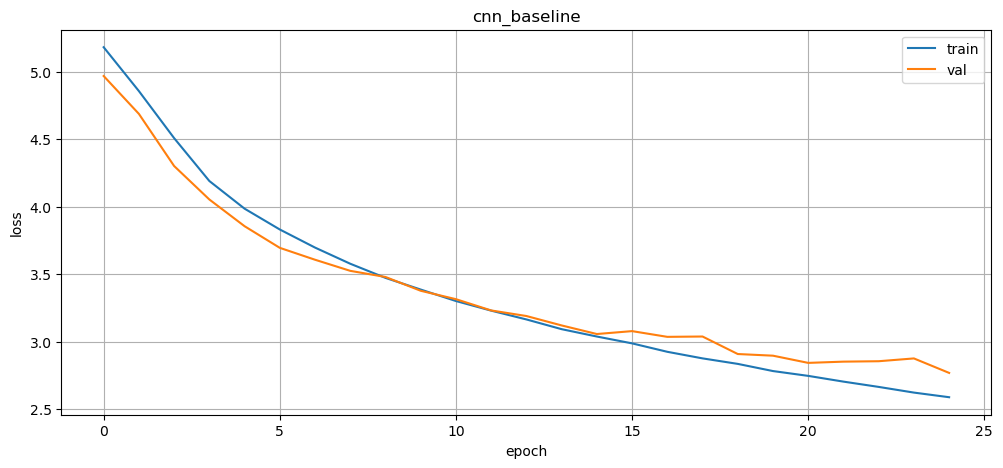

In [28]:
plot_losses(train_losses_baseline, val_losses_baseline, title="cnn_baseline")

In [29]:
def collect_predictions(model, dataloader, device):
    model.eval()
    model = model.to(device)
    torch.set_grad_enabled(False)

    labels_all = []
    probs_all = []
    preds_all = []
    for batch in tqdm(dataloader, total=len(dataloader)):
        images, labels = batch

        logits = model(images.to(device)).cpu()
        probs = logits.softmax(dim=1)
        max_prob, max_prob_index = torch.max(probs, dim=1)

        labels_all.extend(labels.numpy().tolist())
        probs_all.extend(max_prob.numpy().tolist())
        preds_all.extend(max_prob_index.numpy().tolist())

    return labels_all, probs_all, preds_all

In [30]:
train_labels, train_probs, train_preds = collect_predictions(cnn_baseline, train_loader, device)

accuracy_train = accuracy_score(train_labels, train_preds)
accuracy_train

  0%|          | 0/782 [00:00<?, ?it/s]

0.42042

In [31]:
test_labels, test_probs, test_preds = collect_predictions(cnn_baseline, test_loader, device)

accuracy_train = accuracy_score(test_labels, test_preds)
accuracy_train

  0%|          | 0/79 [00:00<?, ?it/s]

0.0028

In [32]:
optimizer = config["optimizer"](
    model.parameters(), 
    lr=config["learning_rate"] * 10, 
    weight_decay=config["weight_decay"]
)

In [33]:
train_losses_baseline, val_losses_baseline, best_val_loss_baseline, cnn_baseline = run_experiment(
    model,
    train_loader,
    val_loader,
    loss_fn,
    optimizer,
    config["num_epochs"],
    device,
    "checkpoints_chatgpt",
    start_epoch=config["num_epochs"]
)

epoch: 025 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 025 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=25_valloss=4.364.pth.tar



epoch: 026 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 026 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=26_valloss=3.955.pth.tar



epoch: 027 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 027 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=27_valloss=3.770.pth.tar



epoch: 028 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 028 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=28_valloss=3.622.pth.tar



epoch: 029 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 029 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=29_valloss=3.510.pth.tar



epoch: 030 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 030 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=30_valloss=3.452.pth.tar



epoch: 031 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 031 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=31_valloss=3.366.pth.tar



epoch: 032 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 032 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=32_valloss=3.307.pth.tar



epoch: 033 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 033 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=33_valloss=3.161.pth.tar



epoch: 034 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 034 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=34_valloss=3.150.pth.tar



epoch: 035 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 035 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=35_valloss=3.101.pth.tar



epoch: 036 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 036 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=36_valloss=3.046.pth.tar



epoch: 037 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 037 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

epoch: 038 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 038 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=38_valloss=3.037.pth.tar



epoch: 039 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 039 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=39_valloss=2.991.pth.tar



epoch: 040 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 040 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=40_valloss=2.967.pth.tar



epoch: 041 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 041 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

epoch: 042 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 042 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=42_valloss=2.942.pth.tar



epoch: 043 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 043 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=43_valloss=2.909.pth.tar



epoch: 044 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 044 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=44_valloss=2.850.pth.tar



epoch: 045 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 045 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=45_valloss=2.844.pth.tar



epoch: 046 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 046 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

epoch: 047 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 047 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=47_valloss=2.819.pth.tar



epoch: 048 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 048 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

epoch: 049 | train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch: 049 | val  :   0%|          | 0/79 [00:00<?, ?it/s]

New checkpoint saved to checkpoints_chatgpt/epoch=49_valloss=2.815.pth.tar

Best val_loss = 2.815 reached at epoch 49


In [34]:
train_labels, train_probs, train_preds = collect_predictions(cnn_baseline, train_loader, device)

accuracy_train = accuracy_score(train_labels, train_preds)
accuracy_train

  0%|          | 0/782 [00:00<?, ?it/s]

0.40509

In [35]:
test_labels, test_probs, test_preds = collect_predictions(cnn_baseline, test_loader, device)

accuracy_train = accuracy_score(test_labels, test_preds)
accuracy_train

  0%|          | 0/79 [00:00<?, ?it/s]

0.0046

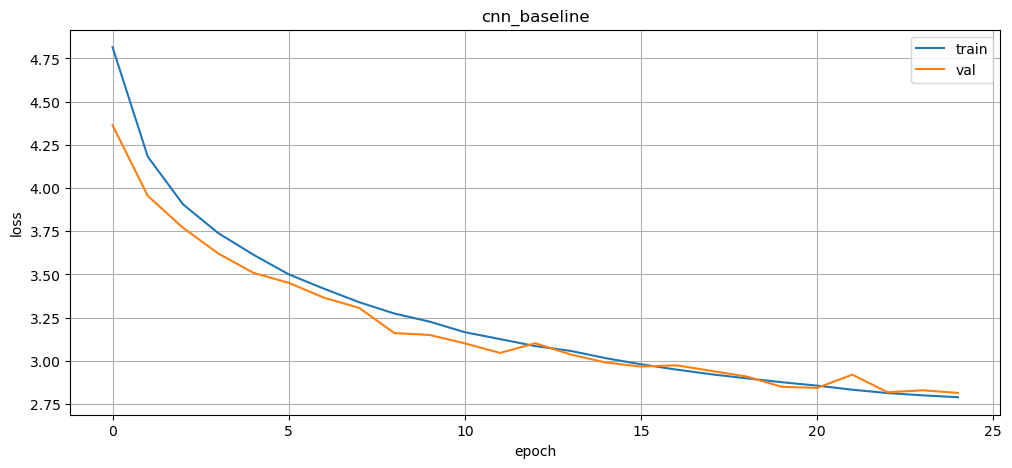

In [37]:
plot_losses(train_losses_baseline, val_losses_baseline, title="cnn_baseline")

In [36]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch_loss_train,█▇▆▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▇▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁
epoch_loss_val,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▆▅▄▄▃▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁
loss,█▇▆▅▄▄▃▄▃▂▃▂▂▁▃▂▂▂▂▁█▆▄▄▄▄▄▃▂▃▃▃▃▂▂▃▂▂▂▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
epoch,49
epoch_loss_train,2.78972
epoch_loss_val,2.81467
loss,2.9403
lr,0.003
